In [1]:
import skforecast
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from dateutil.relativedelta import relativedelta

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster

c:\OneDrive - TRIMEDX Holdings, LLC\Miniconda3\envs\ff_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('database/DIM_PLAYER_GAMES.csv')
data = df.loc[df['PLAYER']=='CeeDee Lamb']
data['FORECAST_DATE'] = pd.date_range("2018-01-01", periods=len(data), freq="MS")
data['FORECAST_DATE'] = pd.to_datetime(data['FORECAST_DATE'], format='%Y-%m-%d')
data = data.set_index('FORECAST_DATE')
data = data.asfreq('MS')
data = data['PPR']


C:\Users\012356.CORPORATE\AppData\Local\Temp\ipykernel_5812\815366217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FORECAST_DATE'] = pd.date_range("2018-01-01", periods=len(data), freq="MS")
C:\Users\012356.CORPORATE\AppData\Local\Temp\ipykernel_5812\815366217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FORECAST_DATE'] = pd.to_datetime(data['FORECAST_DATE'], format='%Y-%m-%d')


FORECAST_DATE
2018-01-01    10.9
2018-02-01    17.5
2018-03-01    11.6
2018-04-01    25.2
2018-05-01    20.4
2018-06-01    13.4
2018-07-01    17.1
2018-08-01    14.6
2018-09-01     7.1
2018-10-01    10.6
2018-11-01     8.1
2018-12-01    13.5
2019-01-01    23.4
2019-02-01     9.6
2019-03-01    23.4
2019-04-01    17.4
2019-05-01     9.5
2019-06-01     3.3
2019-07-01    18.8
2019-08-01    36.1
2019-09-01    17.2
2019-10-01     4.3
2019-11-01    28.6
2019-12-01     4.4
2020-01-01    19.2
2020-02-01     8.1
2020-03-01     6.5
2020-04-01     4.9
2020-05-01    15.1
2020-06-01    22.7
2020-07-01    21.7
2020-08-01    10.3
2020-09-01    12.7
2020-10-01    10.6
2020-11-01    18.8
2020-12-01    38.0
2021-01-01     9.5
2021-02-01    17.7
2021-03-01    20.4
2021-04-01     8.3
2021-05-01    19.7
2021-06-01    34.0
2021-07-01    21.0
2021-08-01    16.2
2021-09-01    11.7
2021-10-01    25.3
2021-11-01    10.2
2021-12-01    14.8
2022-01-01     8.9
2022-02-01    18.7
2022-03-01    41.0
2022-04-01    30.

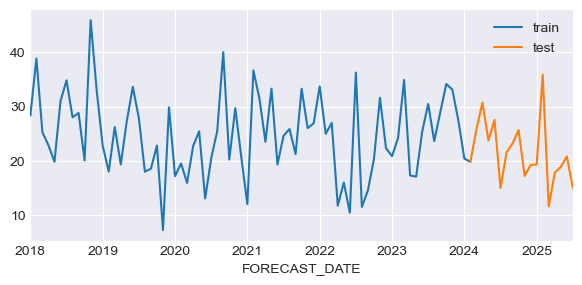

In [65]:
end_train = max(data.index) - relativedelta(months=17)
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend()

In [67]:
forecaster = ForecasterAutoreg(
                 regressor = LinearRegression(),
                 lags      = 17
             )

forecaster.fit(y=data.loc[:max(data.index) - relativedelta(months=18)])
forecaster

ForecasterAutoreg 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] 
Transformer for y: None 
Transformer for exog: None 
Window size: 17 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2018-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False} 
fit_kwargs: {} 
Creation date: 2023-12-22 00:20:35 
Last fit date: 2023-12-22 00:20:35 
Skforecast version: 0.11.0 
Python version: 3.11.3 
Forecaster id: None 

In [68]:
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
predictions.tail(3)

2025-05-01    23.278895
2025-06-01    22.714077
2025-07-01    23.672398
Freq: MS, Name: pred, dtype: float64

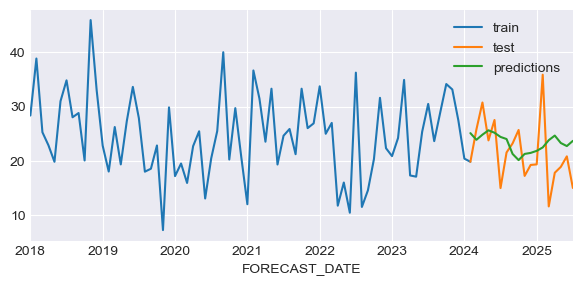

In [69]:
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [70]:
data.loc[end_train:].sum(), predictions.sum()

(388.78000000000003, 419.499523051768)

In [71]:
error_mape = mean_absolute_percentage_error(
                y_true = data.loc[end_train:],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mape}")

Test error (mse): 0.2739338010445675


In [72]:
grid_search_forecaster(forecaster=forecaster, 
                       y=data,
                       lags_grid=[1, 3, 4, 8, 12, 17], 
                       param_grid={},
                       steps=17,
                       metric=mean_absolute_percentage_error, 
                       initial_train_size=len(data)-17)

Number of models compared: 6.


lags grid: 100%|██████████| 6/6 [00:00<00:00, 149.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 74
Number of observations used for backtesting: 17
    Number of folds: 1
    Number of steps per fold: 17
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2024-02-01 00:00:00  (n=74)
    Validation: 2024-03-01 00:00:00 -- 2025-07-01 00:00:00  (n=17)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 74
Number of observations used for backtesting: 17
    Number of folds: 1
    Number of steps per fold: 17
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2024-02-01 00:00:00  (n=74)
    Validation: 2024-03-01 00:00:00 -- 2025-07-01 00:00:00  (n=17)

Information of backtesting process
----------------------------------
Number of observations


c:\OneDrive - TRIMEDX Holdings, LLC\Miniconda3\envs\ff_env\Lib\site-packages\skforecast\model_selection\model_selection.py:1206: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
c:\OneDrive - TRIMEDX Holdings, LLC\Miniconda3\envs\ff_env\Lib\site-packages\skforecast\model_selection\model_selection.py:1206: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results = pd.concat([results, results['params'].apply(pd.Series)], axis=1)
c:\OneDrive - TRIMEDX Holdings, LLC\Miniconda3\envs\ff_env\Lib\site-packages\skforecast\model_selection\model_selection.py:1206: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly 

,lags,params,mean_absolute_percentage_error
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{},0.281513
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},0.289376
3,"[1, 2, 3, 4, 5, 6, 7, 8]",{},0.294538
2,"[1, 2, 3, 4]",{},0.300508
1,"[1, 2, 3]",{},0.303105
0,[1],{},0.308699


In [73]:
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster            = forecaster,
                                   y                     = data,
                                   steps                 = 17,
                                   metric                = 'mean_absolute_percentage_error',
                                   initial_train_size    = len(data.loc[:end_train]),
                                   fixed_train_size      = False,
                                   gap                   = 0,
                                   allow_incomplete_fold = True,
                                   refit                 = True,
                                   n_jobs                = 'auto',
                                   verbose               = True,
                                   show_progress         = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 74
Number of observations used for backtesting: 17
    Number of folds: 1
    Number of steps per fold: 17
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2018-01-01 00:00:00 -- 2024-02-01 00:00:00  (n=74)
    Validation: 2024-03-01 00:00:00 -- 2025-07-01 00:00:00  (n=17)



100%|██████████| 1/1 [00:00<00:00, 185.01it/s]

Backtest error: 0.2815131351478482
